# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import albumentations as A
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2 # To convert NumPy array back to PyTorch Tensor
from torchvision import models
import os


/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),

])
data_dir = "sample_data"

dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), train_transforms)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for images, _ in loader:
    batch_samples = images.size(0)  # batch size
    images = images.view(batch_samples, images.size(1), -1)  # flatten H and W
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4828, 0.4521, 0.4010])
Std: tensor([0.2206, 0.2162, 0.2149])


## Data Transformations



In [2]:
from transforms_module import *

#Albumentations type 2
# CIFAR-10 statistics
MEAN = (0.4830, 0.4523, 0.4013)   # 0–1 scale
STD = (0.2205, 0.2163, 0.2149)    # 0–1 scale
MEAN_255 = tuple([x * 255 for x in MEAN])  # 0–255 scale for cutout fill

train_transforms, test_transforms = get_albumentations_transforms_train_val_2(MEAN, STD,MEAN_255)


/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/session_9/training/ERA4_assignment_9/transforms_module.py:64: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=(0,0,0)),
/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/session_9/training/ERA4_assignment_9/transforms_module.py:78: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/session_9/training/ERA4_assignment_9/transforms_module.py:103: UserWarning: Argument(s) 'value' are not valid for tr

# Dataset and Creating Train/Test Split

In [4]:
data_dir = "sample_data"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), AlbumentationsTransform(train_transforms))
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), AlbumentationsTransform(test_transforms))

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [6]:
# Load not pretrained ResNet34
resnet = models.resnet18(pretrained=None)
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#This reduces the receptive field to fit 32×32 inputs without losing spatial information.
resnet.maxpool = nn.Identity()  # remove 7x7 conv & maxpool for CIFAR
# Replace the final fully connected layer
resnet.fc = nn.Linear(resnet.fc.in_features, 1000)

/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet.to(device)
summary(model, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
          Identity-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
             ReLU-10         [-1, 64, 224, 224]               0
       BasicBlock-11         [-1, 64, 224, 224]               0
           Conv2d-12         [-1, 64, 224, 224]          36,864
      BatchNorm2d-13         [-1, 64, 224, 224]             128
             ReLU-14         [-1, 

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from hyper_parameter_modules import get_hyper_parameters_one_cycle_lr_with_cos_annealing
epochs = 50
CHECKPOINT_DIR = "./checkpoints_version_1"
criterion, optimizer, scheduler = get_hyper_parameters_one_cycle_lr_with_cos_annealing(model, train_loader,epochs)

In [9]:
from train_test_modules import train_test_with_scheduler , training_loop_with_scaler,training_loop_with_scaler_cutmix_mixup

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
# # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1,)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

train_losses, test_losses, train_accuracies, test_accuracies, Learning_Rates, best_accuracies = training_loop_with_scaler_cutmix_mixup(model, device, train_loader, test_loader, optimizer, criterion, scheduler, epochs,CHECKPOINT_DIR)

/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/session_9/training/ERA4_assignment_9/train_test_modules.py:261: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50:   0%|          | 0/2002 [00:00<?, ?it/s]/mnt/fb0d7ad2-8ef1-4b6e-b1d2-0c53fa7701b7/TSAI/ERA/session_9/training/ERA4_assignment_9/train_test_modules.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 2002/2002 [18:48<00:00,  1.77it/s, loss=6.7365, acc=0.56%, lr=0.00252]



Epoch 001 | Train Acc: 0.56% | Val Acc: 1.28% | LR: 0.00252
✅ Saved new best model (1.28%)


Epoch 2/50: 100%|██████████| 2002/2002 [18:37<00:00,  1.79it/s, loss=6.3953, acc=1.20%, lr=0.00408]



Epoch 002 | Train Acc: 1.20% | Val Acc: 2.36% | LR: 0.00408
✅ Saved new best model (2.36%)


Epoch 3/50:  43%|████▎     | 861/2002 [08:11<10:50,  1.75it/s, loss=6.1608, acc=1.77%, lr=0.00504]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Learning Rate')

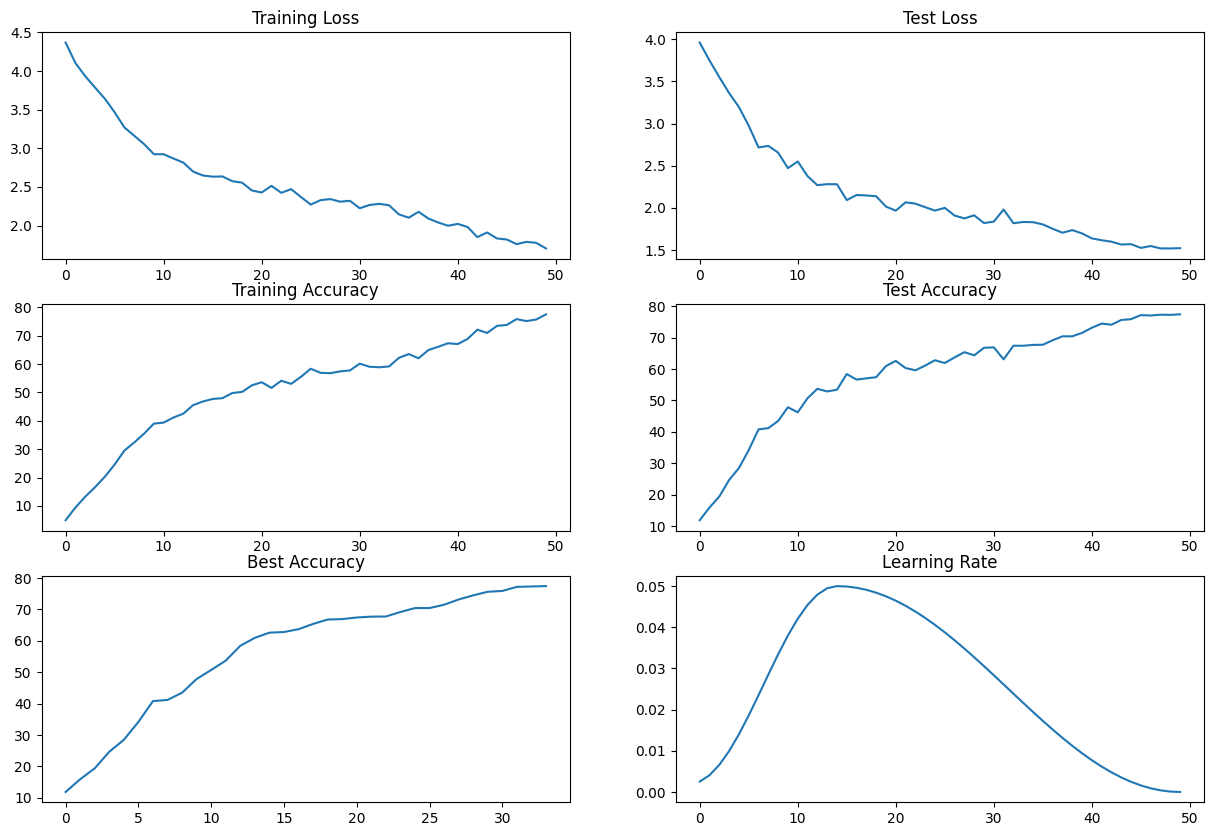

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")
axs[2, 0].plot(best_accuracies)
axs[2, 0].set_title("Best Accuracy")
axs[2, 1].plot(Learning_Rates)
axs[2, 1].set_title("Learning Rate")


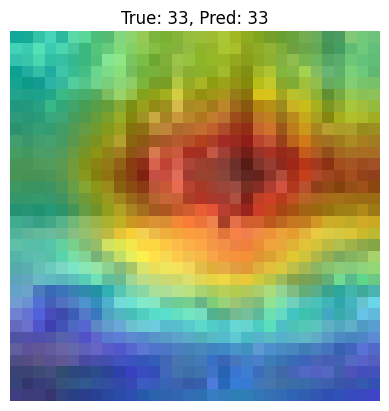

In [ ]:
from grad_cam import *


visualize_grad_cam(model, test_loader, device)

In [15]:


# Example for CIFAR-100
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
class_names = test_dataset.classes  # from torchvision.datasets.CIFAR100

plot_gradcam_for_misclassified(
    model, 
    device, 
    test_loader, 
    class_names=class_names, 
    mean=MEAN, 
    std=STD, 
    num_images=8,  # show 8 misclassified samples
    # layer=4
)

NameError: name 'plot_gradcam_for_misclassified' is not defined

In [ ]:
# plt.savefig("gradcam_misclassified_ver_2.png", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>